In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import argparse
import datetime
import importlib
import os
import tensorflow as tf
import yaml
import math
#from dataset.helper import DatasetHelper
from dataset.nyu13_dataset import NYU13Dataset
from train_utils import *
import sys
sys.path.append('/nethome/shickson3/CreateNormals/')
from python.calc_normals import NormalCalculation


In [2]:
file_address = open('config/nyudv2/test/normals2.config')
config = yaml.load(file_address)
normals_matrix = np.zeros([4])

In [3]:
def compute_normals_matrix(normals_gt, pred, depths, normals_matrix):
    weights = ~((np.squeeze(depths) == 0) + (normals_gt[..., :] == [0,0,0])[..., 0])
    num_weights = float(np.sum(weights))
    gt_norm = normals_gt / (np.linalg.norm(normals_gt,axis=-1, keepdims=True)+1e-10)
    pred_norm = pred / (np.linalg.norm(pred,axis=-1, keepdims=True)+1e-10)
    cos_dist = (gt_norm[..., 0] * pred_norm[..., 0] + gt_norm[..., 1] * pred_norm[..., 1] + gt_norm[..., 2] * pred_norm[..., 2])
    dist_angle = 180.0 / math.pi * np.arccos(np.clip(cos_dist, -1.0, 1.0))
    masked_dist = dist_angle[weights]
    below_11_25 = np.sum(masked_dist <= 11.25) / num_weights
    below_22_5 = np.sum(masked_dist <= 22.5) / num_weights
    below_30 = np.sum(masked_dist <= 30.0) / num_weights
    mean = np.mean(masked_dist)
    normals_matrix += np.array([below_11_25, below_22_5, below_30, mean])
    return normals_matrix


In [4]:
module = importlib.import_module('models.' + config['model'])
model_func = getattr(module, config['model'])
dataset_name = config['dataset_name']
if dataset_name == 'nyu13':
    helper = NYU13Dataset()
elif dataset_name == 'nyu40':
    helper = NYU40Dataset()
elif dataset_name == 'scenenet':
    helper = ScenenetDataset()
elif dataset_name == 'scannet':
    helper = ScannetDataset()
else:
    print('Non-existant Dataset')
helper.Setup(config)
modalities_num_classes, num_label_classes = extract_modalities(config)
data_list, iterator = helper.get_test_data(config, num_label_classes)
resnet_name = 'resnet_v2_50'

with tf.variable_scope(resnet_name):
    model = model_func(modalities_num_classes=modalities_num_classes, training=False)
    images_pl, depths_pl, normals_pl, labels_pl, update_ops = setup_model(model, config, train=False)

config1 = tf.ConfigProto()
config1.gpu_options.allow_growth = True
sess = tf.Session(config=config1)
sess.run(tf.global_variables_initializer())
import_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
print 'total_variables_loaded:', len(import_variables)
saver = tf.train.Saver(import_variables)
saver.restore(sess, config['checkpoint'])
#sess.run(iterator.initializer)
step = 0
total_num = 0
labels_matrix = np.zeros([num_label_classes, 3])
normals_matrix = np.zeros([4])
start_step = 0

W0904 12:07:49.030322 139682618185472 deprecation.py:323] From dataset/helper.py:105: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0904 12:07:49.057249 139682618185472 deprecation.py:323] From dataset/helper.py:123: make_one_shot_iterator (from tensorflow.python.data.

Network_Construction
total_variables_loaded:

W0904 12:07:52.774264 139682618185472 deprecation.py:323] From /home/steve/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


 388


In [5]:
feed_dict = setup_feeddict(data_list, sess, images_pl, depths_pl, normals_pl, labels_pl, config)

In [6]:
inputs = []
for mod in config['output_modality']:
    if mod == 'labels':
        inputs.append(model.softmax)
    elif mod == 'normals':
        inputs.append(model.output_normals)
results = sess.run(inputs, feed_dict=feed_dict)
for mod, result in zip(config['output_modality'], results):
    if mod == 'labels':
        labels_matrix = get_label_metrics(result, feed_dict, labels_pl, labels_matrix)
    elif mod == 'normals':
        normals_matrix = compute_normals_matrix(feed_dict[normals_pl], result, feed_dict[depths_pl], normals_matrix)

total_num += config['batch_size']
print normals_matrix

[ 0.17046938  0.49891574  0.61745405 32.26968002]


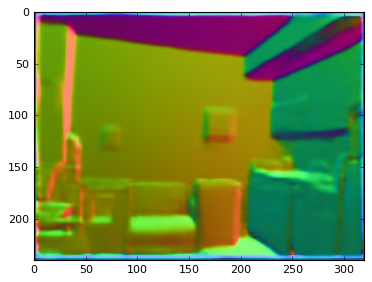

In [7]:
t = 0
output_normals = results[0]
test_normal = output_normals[t,:,:,:]
test_normal = test_normal / (np.linalg.norm(test_normal,axis=-1, keepdims=True)+1e-10)
plt.imshow((test_normal + 1.0) / 2.0)

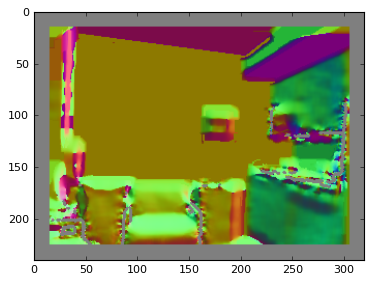

In [8]:
input_normals = feed_dict[normals_pl]
gt_normal = input_normals[t,:,:,:]
gt_normal = gt_normal / (np.linalg.norm(gt_normal,axis=-1, keepdims=True)+1e-10)
plt.imshow((gt_normal + 1.0) / 2.0)

(240, 320)


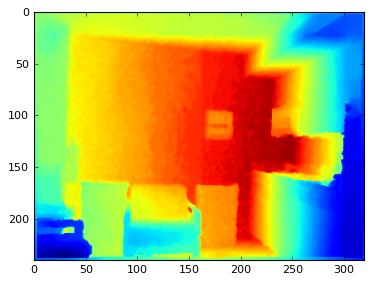

In [9]:
depths = feed_dict[depths_pl]
gt_depth = depths[t,:,:,:].reshape((240,320))
print gt_depth.shape
plt.imshow(gt_depth)

(240, 320)
59494.0
bool
bool


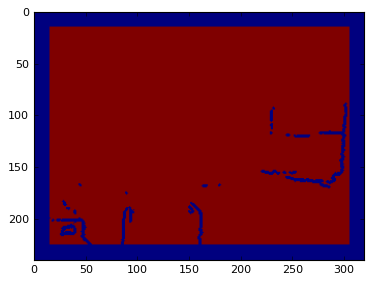

In [10]:
weights = ~((np.squeeze(depths) == 0) + (input_normals[..., :] == [0,0,0])[..., 0])
input_weight = weights[t,...]
print input_weight.shape
plt.imshow(input_weight)
print(float(np.sum(input_weight)))
print input_weight.dtype
print weights.dtype

In [11]:
normals_matrix = [0,0,0,0]
print(compute_normals_matrix(gt_normal, test_normal, gt_depth, normals_matrix))

[ 0.19427169  0.67075671  0.74856288 25.49754715]


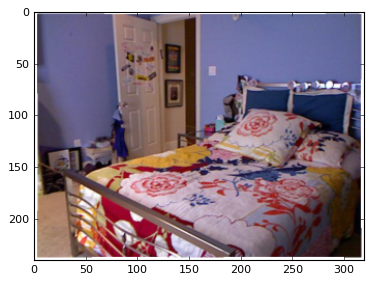

In [46]:
rgb = feed_dict[images_pl]
test_rgb = ((rgb[t,...]+ 63.75) * 2).astype(np.uint8)
plt.imshow(test_rgb)

In [13]:
nyu_mapping = [40,40,3,22,5,40,12,38,40,40,2,39,40,40,26,40,24,40,7,40,1,40,40,34
                    ,38,29,40,8,40,40,40,40,38,40,40,14,40,38,40,40,40,15,39,40,30,40,40,39
                    ,40,39,38,40,38,40,37,40,38,38,9,40,40,38,40,11,38,40,40,40,40,40,40,40
                    ,40,40,40,40,40,40,38,13,40,40,6,40,23,40,39,10,16,40,40,40,40,38,40,40
                    ,40,40,40,40,40,40,40,38,40,39,40,40,40,40,39,38,40,40,40,40,40,40,18,40
                    ,40,19,28,33,40,40,40,40,40,40,40,40,40,38,27,36,40,40,40,40,21,40,20,35
                    ,40,40,40,40,40,40,40,40,38,40,40,40,4,32,40,40,39,40,39,40,40,40,40,40
                    ,17,40,40,25,40,39,40,40,40,40,40,40,40,40,39,40,40,40,40,40,40,40,40,40
                    ,40,40,40,40,40,40,40,40,40,40,40,39,40,40,40,40,40,40,40,40,40,39,38,38
                    ,40,40,39,40,39,40,38,39,38,40,40,40,40,40,40,40,40,40,40,39,40,38,40,40
                    ,38,38,40,40,40,40,40,40,40,40,40,40,40,40,40,38,40,40,40,40,40,39,40,40
                    ,40,40,40,40,40,40,40,40,40,40,40,40,40,39,40,40,40,40,40,40,40,40,40,40
                    ,40,40,39,40,40,40,38,40,40,39,40,40,38,40,40,40,40,40,40,40,40,40,40,40
                    ,39,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,31,40,40,40,40,40
                    ,40,40,38,40,40,38,39,39,40,40,40,40,40,40,40,40,40,38,40,39,40,40,39,40
                    ,40,40,38,40,40,40,40,40,40,40,40,38,39,40,40,40,40,40,40,38,40,40,40,40
                    ,40,40,40,40,40,40,40,38,39,40,40,40,40,40,40,40,39,40,40,40,40,40,40,38
                    ,40,40,40,38,40,39,40,40,40,39,39,40,40,40,40,40,40,40,40,40,40,39,40,40
                    ,40,40,40,40,40,40,40,40,40,40,39,39,40,40,39,39,40,40,40,40,38,40,40,38
                    ,39,39,40,39,40,39,38,40,40,40,40,40,40,40,40,40,40,40,39,40,38,40,39,40
                    ,40,40,40,40,39,39,40,40,40,40,40,40,39,39,40,40,38,39,39,40,40,40,40,40
                    ,40,40,40,40,39,39,40,40,40,40,39,40,40,40,40,40,39,40,40,39,40,40,40,40
                    ,40,40,40,40,40,40,40,40,40,40,40,39,38,40,40,40,40,40,40,40,39,38,39,40
                    ,38,39,40,39,40,39,40,40,40,40,40,40,40,40,38,40,40,40,40,40,38,40,40,39
                    ,40,40,40,39,40,38,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,40,40,40
                    ,40,40,40,40,40,40,40,39,38,40,40,38,40,40,38,40,40,40,40,40,40,40,40,40
                    ,39,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,38,40,40,38,40,40,40
                    ,40,40,40,40,40,40,40,40,38,38,38,40,40,40,38,40,40,40,38,38,40,40,40,40
                    ,40,40,40,40,40,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,40,40,40,40
                    ,40,40,40,38,40,38,39,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
                    ,40,40,40,40,40,40,40,40,40,40,40,40,40,39,40,40,40,40,40,40,40,40,40,40
                    ,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
                    ,40,39,40,39,40,40,40,40,38,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40
                    ,40,40,40,40,39,40,40,39,40,40,39,39,40,40,40,40,40,40,40,40,39,39,39,40
                    ,40,40,40,39,40,40,40,40,40,40,40,40,39,40,40,40,40,40,39,40,40,40,40,40
                    ,40,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,40,39,40,40,38,40,39,40
                    ,40,40,40,38,40,40,40,40,40,38,40,40,40,40,40,40,40,39,40,40,40,40,40,40
                    ,40,40,40,39,40,40]
nyu_mapping.insert(0,0)
#Scannet Flat Labels
# Category = ID, NYU40 ID
# Wall = 1, 1
# floor = 3, 2
# door = 5, 8
# window = 16, 9
# table = 4, 7
# picture = 15, 11
# ceiling = 41, 22
# box = 26, 29
# doorframe = 161, 8
# desk = 9, 14
# shelf = 8, 15 (maybe exclude this?)
# mirror = 71, 19
# whiteboard = 52, 30
# coffee table = 24, 7
# nightstand = 34, 32
# computer tower = 64, 40 (also telephone and cup so let's ignore this)
# fridge = 27, 24
# end table = 44, 7
# shower walls = 128, 1
# closet wall = 1165, 1


In [14]:
target = [1,2,8,9,7,11,22,29,14,19,30,32,24]
for i in range(0,len(nyu_mapping)):
    if nyu_mapping[i] in target:
        print(i)

4
11
17
19
21
26
28
36
45
59
64
122
158


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
(480, 640)


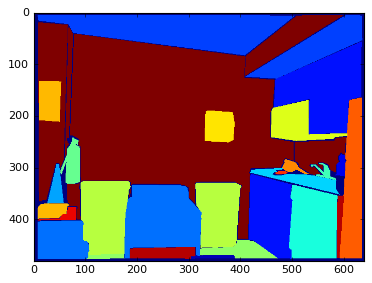

In [15]:
labels = cv2.imread('/data/nyudv2/labels/0.png', cv2.IMREAD_ANYDEPTH)
plt.imshow(labels)
print np.unique(labels)
print labels.shape

[1798 1799 1800 ... 3606 3614 3615]
(480, 640)


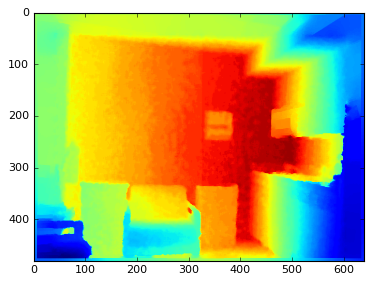

In [16]:
new_depth = cv2.imread('/data/nyudv2/depth/0.png', cv2.IMREAD_ANYDEPTH)
plt.imshow(new_depth)
print np.unique(new_depth)
print new_depth.shape

In [17]:
camera_params = [238.44,0,313.04,0,582.69,242.74,0,0,1]
normal_params = [5,0.02,30,0.04]
flat_labels = [4,11,17,19,21,26,28,36,45,59,64,122,158]
norm_calc = NormalCalculation(camera_params, normal_params, flat_labels)
new_normals = norm_calc.Calculate(new_depth, labels)

[4, 11, 17, 19, 21, 26, 28, 36, 45, 59, 64, 122, 158]


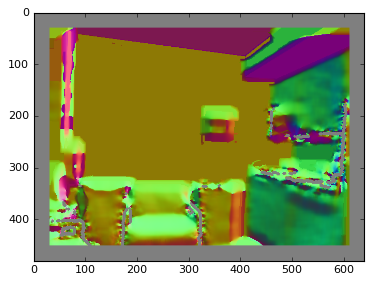

In [18]:
plt.imshow((new_normals + 1.0) / 2.0)

(480, 640)


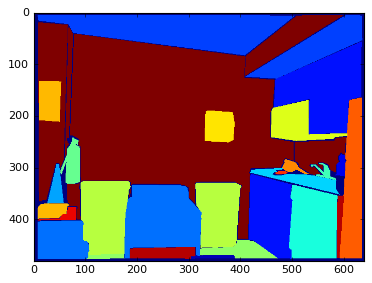

In [19]:
labels_saved = cv2.imread('labels.png', cv2.IMREAD_ANYDEPTH)
print labels_saved.shape
plt.imshow(labels_saved)

In [25]:
diff = cv2.resize(new_normals, (320,240), interpolation=cv2.INTER_NEAREST) - gt_normal

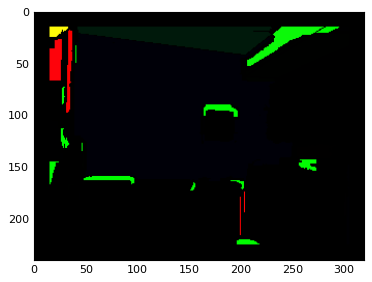

In [27]:
plt.imshow(diff)